#### Setup

In [1]:
%pip install -q numpy pandas matplotlib seaborn scikit-learn tensorflow keras

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: C:\Users\jfsal\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


#### Imports

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


#### Load Data

In [3]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')


#### Data Cleaning

In [4]:
train = train.drop('Id', axis = 1)
ids = test.pop('Id')

In [5]:
print(train.columns)

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

#### Feature Engineering

In [6]:
def add_features(data):
    data['HouseAge'] = data['YrSold'] - data['YearBuilt']
    data['RemodAge'] = data['YrSold'] - data['YearRemodAdd']
    data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']
    data['TotalSF'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF']

    return data

train = add_features(train)
test = add_features(test)

#### Data Preprocessing

In [7]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
def preprocess(dataframe, cat_columns, num_columns):
    encoder = OneHotEncoder(sparse_output = False,
                            handle_unknown = 'ignore')
    scaler = StandardScaler()

    #encode categorical columns
    encoded_cols = encoder.fit_transform(dataframe[cat_columns])
    encoded_df = pd.DataFrame(encoded_cols, columns = encoder.get_feature_names_out(cat_columns))
    dataframe = pd.concat([dataframe.reset_index(drop = True), encoded_df.reset_index(drop = True)], axis = 1)

    #scale numerical columns
    scaled_cols = scaler.fit_transform(dataframe[num_columns])
    scaled_df = pd.DataFrame(scaled_cols, columns = num_columns)
    dataframe = pd.concat([dataframe.reset_index(drop = True), scaled_df.reset_index(drop = True)], axis = 1)

    #drop original columns
    dataframe.drop(columns = cat_columns + num_columns, inplace = True)
    return dataframe

cat_cols = ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood',
            'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st',
            'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
            'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType',
            'GarageFinish', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType',
            'MoSold', 'YrSold', 'SaleCondition']
num_cols = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
            'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
            'PoolArea', 'MiscVal', 'GarageYrBlt', 'HouseAge', 'RemodAge', 'GarageAge', 'TotalSF']

train = preprocess(train, cat_cols, num_cols)
test = preprocess(test, cat_cols, num_cols)



In [8]:
print(train.columns)
print(test.columns)
print(train.shape)
print(test.shape)

Index(['SalePrice', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40',
       'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70',
       'MSSubClass_75', 'MSSubClass_80',
       ...
       'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=324)
Index(['MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MSSubClass_75',
       'MSSubClass_80', 'MSSubClass_85',
       ...
       'YrSold_2007', 'YrSold_2008', 'YrSold_2009', 'YrSold_2010',
       'SaleCondition_Abnorml', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Normal',
       'SaleCondition_Partial'],
      dtype='object', length=314)
(1460, 324)
(1459, 314)


In [9]:
missing_cols = set(test.columns) - set(train.columns)
print(missing_cols)
print(len(missing_cols))

{'GarageCars_2.0', 'Exterior2nd_nan', 'GarageCars_1.0', 'Utilities_nan', 'GarageCars_nan', 'GarageCars_3.0', 'GarageCars_4.0', 'Functional_nan', 'MSSubClass_150', 'SaleType_nan', 'GarageCars_5.0', 'GarageCars_0.0', 'MSZoning_nan', 'KitchenQual_nan', 'Exterior1st_nan'}
15


In [10]:
for col in missing_cols:
    train[col] = 0

missing_cols = set(test.columns) - set(train.columns)
print(len(missing_cols))

0


In [11]:
print(train.columns)

Index(['SalePrice', 'MSSubClass_20', 'MSSubClass_30', 'MSSubClass_40',
       'MSSubClass_45', 'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70',
       'MSSubClass_75', 'MSSubClass_80',
       ...
       'GarageCars_3.0', 'GarageCars_4.0', 'Functional_nan', 'MSSubClass_150',
       'SaleType_nan', 'GarageCars_5.0', 'GarageCars_0.0', 'MSZoning_nan',
       'KitchenQual_nan', 'Exterior1st_nan'],
      dtype='object', length=339)


#### Modeling

In [12]:
from sklearn.model_selection import train_test_split
#create train test split for model
X = train.drop(columns = 'SalePrice')
y = train['SalePrice']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.2)

train_tensor = tf.convert_to_tensor(X_train, dtype = tf.float32)
valid_tensor = tf.convert_to_tensor(X_valid, dtype = tf.float32)

train_labels = tf.convert_to_tensor(y_train, dtype = tf.float32)
valid_labels = tf.convert_to_tensor(y_valid, dtype = tf.float32)

In [18]:
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from kerastuner import HyperModel
from kerastuner.tuners import BayesianOptimization
from tensorflow.keras.metrics import RootMeanSquaredError

class HousePriceHyperModel(HyperModel):
    def build(self, hp):
        model = keras.Sequential()
        model.add(layers.Input(shape=(X_train.shape[1],)))
        model.add(layers.BatchNormalization())

        for i in range(hp.Int('num_layers', 1, 7)):
            units = hp.Int('units_' + str(i), 
                           min_value=256,
                           max_value=1024,
                           step=256)
            activation = 'relu'
            
            # Add regularization
            kernel_regularizer = regularizers.l1(hp.Float('l1_regularization_' + str(i), 
                                                          min_value=1e-6, 
                                                          max_value=1e-3, 
                                                          sampling='LOG'))

            model.add(layers.Dense(units=units,
                                   activation=activation,
                                   kernel_regularizer=kernel_regularizer))
            model.add(layers.BatchNormalization())
            model.add(layers.Dropout(hp.Float('dropout_' + str(i),
                                              min_value=0.2,
                                              max_value=0.5,
                                              step=0.1)))
        model.add(layers.Dense(1, activation='linear'))

        model.compile(
            optimizer=keras.optimizers.Adam(
                learning_rate=hp.Float('learning_rate', 
                                       min_value=1e-5,
                                       max_value=1e-2,
                                       sampling='LOG')
            ),
            loss='mse',
            metrics=['mean_absolute_error', RootMeanSquaredError()]
        )
        return model
    
tuner = BayesianOptimization(
    HousePriceHyperModel(),
    objective='val_mean_absolute_error',
    max_trials=100,  # Number of hyperparameter combinations to try
    directory='House Price Tuning',
    project_name='House Price Prediction',
    overwrite=True
)

#********************#
MY_PATIENCE = 10
MY_EPOCHS = 500
MY_MIN_DELTA = 0.001
#********************#

tuner.search(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=MY_EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(patience=MY_PATIENCE, min_delta=MY_MIN_DELTA, restore_best_weights=True)]
)

best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparams = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error', RootMeanSquaredError()])
best_model.evaluate(X_valid, y_valid)

Trial 73 Complete [00h 00m 35s]
val_mean_absolute_error: 183826.34375

Best val_mean_absolute_error So Far: 183826.34375
Total elapsed time: 00h 15m 27s

Search: Running Trial #74

Value             |Best Value So Far |Hyperparameter
1                 |6                 |num_layers
512               |256               |units_0
0.0009684         |1.736e-05         |l2_regularization_0
0.2               |0.4               |dropout_0
0.00020678        |0.00022731        |learning_rate
512               |768               |units_1
5.0085e-06        |3.4881e-05        |l2_regularization_1
0.4               |0.3               |dropout_1
256               |1024              |units_2
0.00034599        |1.3098e-05        |l2_regularization_2
0.4               |0.4               |dropout_2
768               |1024              |units_3
0.00049456        |0.00023913        |l2_regularization_3
0.2               |0.4               |dropout_3
768               |256               |units_4
4.3366e-06 

C:\Users\jfsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras_tuner\src\tuners\hyperband.py:435: UserWarning: Model 'sequential' had a build config, but the model cannot be built automatically in `build_from_config(config)`. You should implement `def build_from_config(self, config)`, and you might also want to implement the method  that generates the config at saving time, `def get_build_config(self)`. The method `build_from_config()` is meant to create the state of the model (i.e. its variables) upon deserialization.
  model.build_from_config(
C:\Users\jfsal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_pa

#### Plot RMSE of Best Model

Epoch 1/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 1016472064.0000 - mean_squared_error: 1016472064.0000 - root_mean_squared_error: 31775.4648 - val_loss: 2050835328.0000 - val_mean_squared_error: 2050835328.0000 - val_root_mean_squared_error: 45286.1484
Epoch 2/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1106352256.0000 - mean_squared_error: 1106352256.0000 - root_mean_squared_error: 33175.6875 - val_loss: 2162055936.0000 - val_mean_squared_error: 2162055936.0000 - val_root_mean_squared_error: 46497.9141
Epoch 3/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 874511360.0000 - mean_squared_error: 874511360.0000 - root_mean_squared_error: 29480.2305 - val_loss: 2140443648.0000 - val_mean_squared_error: 2140443648.0000 - val_root_mean_squared_error: 46264.9297
Epoch 4/500
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 820952704.0000 - mean_squared_error: 820952704.0000 - root_mean_squared_error: 28538.2441 - val_loss: 2255544832.0000 - val_mean_squared_error: 225554

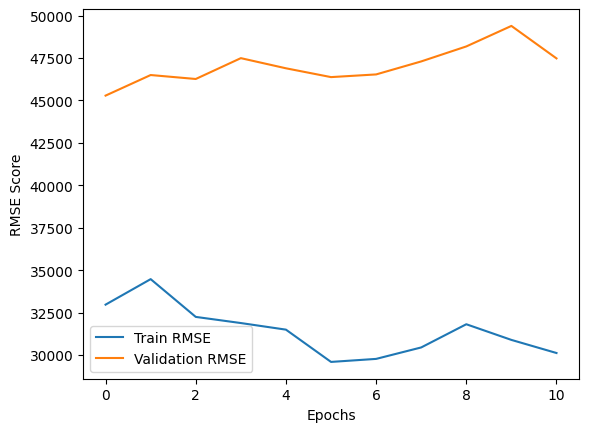

In [17]:
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    epochs=MY_EPOCHS,
    callbacks=[keras.callbacks.EarlyStopping(patience=MY_PATIENCE, min_delta=MY_MIN_DELTA, restore_best_weights=True)]
)


sns.set_style('whitegrid')
sns.set_context('notebook')

plt.figure(figsize=(10, 6))
sns.lineplot(data=history.history['root_mean_squared_error'], label='Train RMSE', marker='o')
sns.lineplot(data=history.history['val_root_mean_squared_error'], label='Validation RMSE', marker='o')


plt.xlabel('Epochs', fontsize=14)
plt.ylabel('RMSE Score', fontsize=14)
plt.title('Training and Validation RMSE over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.show()

#### Output Predictions

In [ ]:
# Verify the shape of X_train and test
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of test: {test.shape}")

missing_features = set(X_train.columns) - set(test.columns)
print(f"Missing features: {missing_features}")

for features in missing_features:
    test[features] = 0

In [ ]:
predictions = best_model.predict(test)

predictions = predictions.flatten()
output_df = pd.DataFrame({'Id': ids, 'SalePrice': predictions})
output_df.to_csv('NN_predictions.csv', index=False)